## Stock Analysis Engine

Analyze information about publicly traded companies from Yahoo (https://finance.yahoo.com/) and IEX Real-Time Price https://iextrading.com/developer/docs/ (supported data includes: news, quotes, dividends, daily, intraday, statistics, financials, earnings, options, and more). Once collected the data is archived in s3 (using minio https://minio.io) and automatically cached in redis.

It uses Celery workers to process all tasks http://www.celeryproject.org/ and is a horizontally scalable worker pool that works with many transports and backends (https://github.com/celery/celery#transports-and-backends)


## Getting Started

### Start Services

To develop jupyter notebooks start the notebook-integration (https://github.com/AlgoTraders/stock-analysis-engine/blob/master/compose/notebook-integration.yml) containers using docker-compose. Here's the command to start it:

```
./compose/start.sh -j
```

Verify the containers are running:

```
docker ps -a
```

### Download and Prepare Data

With a valid internet connection you can the following download datasets from IEX and Yahoo. 

#### IEX via pyEX

- minute (intraday)
- daily
- stats
- peers
- news
- financials
- earnings
- dividends
- company

#### Yahoo

- pricing
- options
- news

Note, please refer to the latest data that is fetched for these services:

- IEX - https://github.com/AlgoTraders/stock-analysis-engine/blob/master/analysis_engine/iex/fetch_data.py
- Yahoo - https://github.com/AlgoTraders/stock-analysis-engine/blob/master/analysis_engine/yahoo/get_data.py

### Load 

In [5]:
import datetime
from spylunking.log.setup_logging import build_colorized_logger

log = build_colorized_logger(name='intro-nb')

### Set up Collection

In [3]:
from analysis_engine.api_requests import build_get_new_pricing_request

ticker = 'SPY'

# Store in this S3 key:
s3_bucket = 'tutorials'
s3_key = '{}_intro_{}'.format(ticker, datetime.datetime.now().strftime('%Y-%m-%d'))

# Store in this Redis key
redis_key = '{}_latest'.format(ticker)

"""
Build the request (a work dictionary):
https://github.com/AlgoTraders/stock-analysis-engine/blob/master/analysis_engine/api_requests.py#L49
"""
work = build_get_new_pricing_request()

work['ticker'] = ticker
work['fetch_mode'] = 'all'
work['s3_key'] = s3_key
work['redis_key'] = redis_key
work['label'] = '{}'.format(s3_key)
work['celery_disabled'] = True

log.info(
    'starting collection ticker={} '
    'redis_key={} s3_bucket={} s3_key={}'.format(
        ticker,
        redis_key,
        s3_bucket,
        s3_key))

2018-10-05 06:30:38,290 - intro-nb - INFO - starting collection ticker=SPY redis_key=SPY_latest s3_bucket=tutorials s3_key=SPY_intro_2018-10-05


In [ ]:
import analysis_engine.work_tasks.get_new_pricing_data as task_pricing
task_res = task_pricing.run_get_new_pricing_data(
    work_dict=work)
log.info('Intro ticker={} collection completed'.format(ticker))

### Extracting Dataset

In [4]:
import analysis_engine.iex.extract_df_from_redis \
    as extract_utils

extract_req = work
extract_req['redis_key'] = '{}_minute'.format(work['redis_key'])

log.info('extracting - start - ticker={} from redis_key={}'.format(ticker, extract_req['redis_key']))
extract_status, minute_df = extract_utils.extract_minute_dataset(work_dict=work)
log.info('extracting - done - ticker={} from redis_key={}'.format(ticker, extract_req['redis_key']))

2018-10-05 06:30:55,009 - intro-nb - INFO - extracting - start - ticker=SPY from redis_key=SPY_latest_minute
2018-10-05 06:30:55,013 - analysis_engine.iex.extract_df_from_redis - INFO - SPY_intro_2018-10-05 - minute - start
2018-10-05 06:30:55,017 - analysis_engine.extract_utils - INFO - SPY_intro_2018-10-05 - minute - START - ds_id=SPY scrub_mode=sort-by-date redis=True redis_address=redis:6379@4 redis_key=SPY_latest_minute s3=True s3_address=minio:9000 s3_bucket=pricing s3_key=SPY_intro_2018-10-05
2018-10-05 06:30:55,021 - analysis_engine.build_df_from_redis - INFO - SPY_intro_2018-10-05 calling get redis key=SPY_latest_minute
2018-10-05 06:30:55,024 - analysis_engine.get_data_from_redis_key - INFO - SPY_intro_2018-10-05 get key=SPY_latest_minute
2018-10-05 06:30:55,034 - analysis_engine.get_data_from_redis_key - INFO - SPY_intro_2018-10-05 decoding key=SPY_latest_minute encoding=utf-8
2018-10-05 06:30:55,049 - analysis_engine.get_data_from_redis_key - INFO - SPY_intro_2018-10-05 des

2018-10-05 06:32:00,734 - intro-nb - INFO - ticker=SPY creating chart date=2018-10-05
2018-10-05 06:32:00,738 - analysis_engine.charts - INFO - intro-nb-SPY - plot_overlay_pricing_and_volume - start


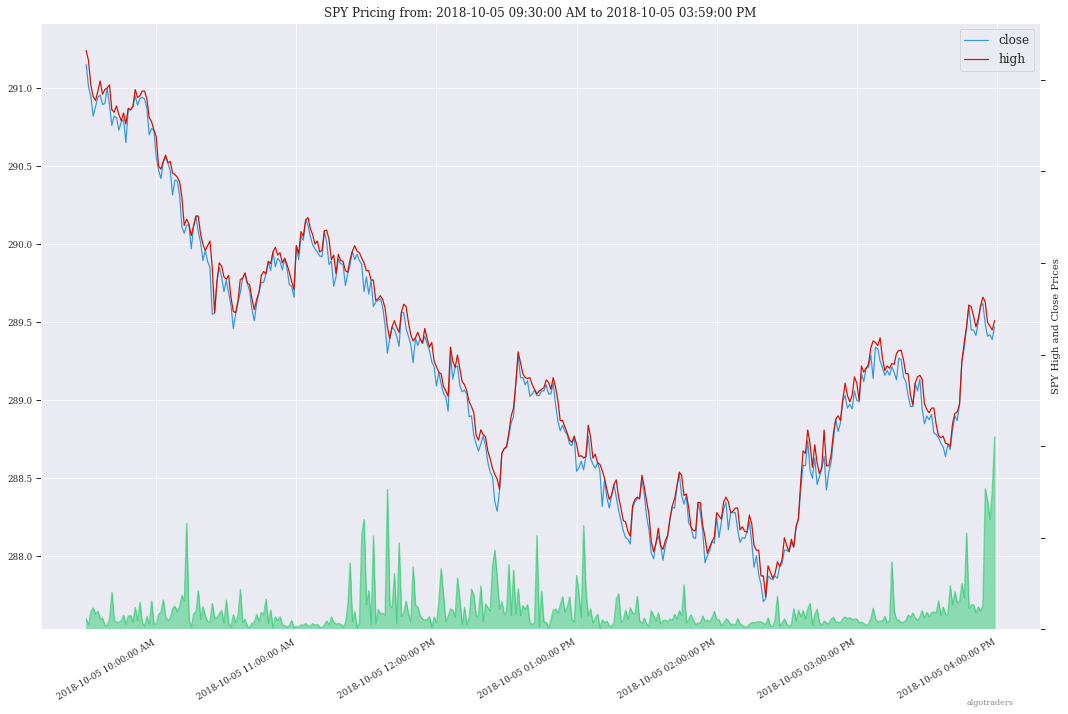

2018-10-05 06:32:01,439 - analysis_engine.charts - INFO - intro-nb-SPY - plot_overlay_pricing_and_volume - done status=SUCCESS err=None


In [9]:
import analysis_engine.charts as ae_charts
from analysis_engine.consts import SUCCESS
from analysis_engine.consts import IEX_MINUTE_DATE_FORMAT

today_str = datetime.datetime.now().strftime(
    '%Y-%m-%d')
if extract_status == SUCCESS:
    log.info(
        'ticker={} creating chart date={}'.format(
            ticker,
            today_str))
    """
    Plot Pricing with the Volume Overlay:
    """
    image_res = ae_charts.plot_overlay_pricing_and_volume(
        log_label='intro-nb-{}'.format(ticker),
        ticker=ticker,
        date_format=IEX_MINUTE_DATE_FORMAT,
        df=minute_df,
        show_plot=True)
else:
    log.error('ticker={} - did not extract a dataset from redis_key={}'.format(ticker, work['redis_key']))